# Особенности посторения процесса обучения нейронной сети

Больше о настройке обучения нейронных сетей можно найти, например, в:
* [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) от Анедрея Карпатых.
* [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187) - статья 2018 год об обучении сверточных нейронных сетей
* [Tips for Model Training](https://docs.ultralytics.com/guides/model-training-tips/#community-resources) от известной команды `ultralytics` и другие гайд от них и других команд. 
* и в других тематических публикациях известных специалистов, например [тут](https://sebastianraschka.com/blog/2023/pytorch-faster.html), [тут](https://github.com/vahidk/EffectivePyTorch), [тут](https://github.com/rasbt/deeplearning-models)  а также официальные публикации `PyTorch`, [например](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html), и известные коллекции примеров, [например](https://madewithml.com/) или [тут](https://github.com/Conchylicultor/Deep-Learning-Tricks). 
<!-- и [тут](https://stackoverflow.com/questions/70554413/how-to-improve-the-performance-of-cnn-model-for-a-specific-dataset-getting-low). -->
* Важно также иметь в виду вопросы ускорения и вычислительной оптимизации обучения нейронных сетей, см., [например](https://habr.com/ru/companies/wunderfund/articles/820721/).
* А также важно иметь в виду вопросы настройки гиперпараметров обучения нейронных сетей, см., [например](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) и [тут](https://docs.ray.io/en/latest/tune/getting-started.html) и [тут](https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html).
* Курс включающий много примеров [тут](https://deeplearning.neuromatch.io/tutorials/W1D5_Optimization/chapter_title.html).
* Гайд [Deep Learning Tuning Playbook](https://github.com/google-research/tuning_playbook)
* [некоторые заметки](https://habr.com/ru/companies/magnus-tech/articles/846012/)
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

Рецепты в библиотеках
* [`skorch`](https://github.com/skorch-dev/skorch)
* [`bitsandbytes`](https://huggingface.co/docs/bitsandbytes/)

## Импорт

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics import Accuracy, Precision, Recall, F1Score
import pandas as pd

In [2]:
import os
import urllib
if not os.path.exists('torch_trainer.py' ):
    url = "https://github.com/MVRonkin//Computer-Vision-Course_lec-practice/raw/refs/heads/main/2025//WS/torch_trainer.py"
    filename, headers = urllib.request.urlretrieve(url,filename='torch_trainer.py' )

In [3]:
from torch_trainer import *

Настроим работу с `PyTorch` при помощи функции `setup_experiment`. Выбирем формат работы и устройство для работы.

 Настраивает окружение для воспроизводимых экспериментов в PyTorch.

-  `seed (int)`: Сид для генераторов случайных чисел `(Python, NumPy, PyTorch)`.
-  `deterministic (bool)`: Включить детерминированное поведение операций `CuDNN` (может снизить скорость).
-  `benchmark (bool)`: Включить CuDNN benchmark для автоматического выбора быстрых алгоритмов (не совместимо с `deterministic=True`).
-  `allow_tf32 (bool)`: Разрешить использование TensorFloat32 на Ampere+ GPU (ускоряет вычисления с небольшой потерей точности).
-  `device_preference (str)`: `"cpu", "cuda", "mps"`, или `"auto"` — выбор устройства.

возвращается Устройство, на котором будут выполняться вычисления.

In [4]:
device = setup_experiment(seed=42, device_preference="auto")

[✓] Device: cuda | Seed: 42 | TF32: True


# Обзор библиотеки `timm`

In [5]:
import timm

Библиотека [timm (PyTorch Image Models)](https://huggingface.co/timm) один из самых востребованных инструментов для задач компьютерного зрения по  классификации изображений, а также для построения мощных `feature extractor` для более сложных архитектур. [Библиотека `timm`](https://github.com/huggingface/pytorch-image-models) поддерживает более 1000 предобученных моделей и имеет тесную интеграцию с экосистемой `Hugging Face`.

<!-- [Библиотека `timm`](https://huggingface.co/docs/timm/index) предоставляет встроенная поддержка `transfer learnin`: — например, замену головной части классификатора под нужное число классов или указание количество входных каналов (обычно 3 для `RGB`-изображений или 1 для `grayscale`). Это особенно удобно при работе с нестандартными доменами — от медицинских снимков до спутниковых изображений.

Помимо моделей, [библиотека `timm`](https://github.com/huggingface/pytorch-image-models) предоставляет готовые и согласованные пайплайны обработки данных, включая автоматическую настройку аугментаций и нормализации под конкретную архитектуру через `timm.data.create_transform()` и `resolve_data_config()`. Это гарантирует, что входные данные будут обработаны так же, как и при оригинальном предобучении — критически важное условие для стабильной и точной инференции.

[Библиотека `timm`](https://huggingface.co/docs/timm/index) полностью совместим с `Hugging Face Hub`: модели можно не только загружать напрямую из репозиториев `Hugging Face`, но и публиковать собственные веса, делая их доступными для сообщества. Такая интеграция упрощает воспроизводимость экспериментов и совместную работу. -->




Модели в `Timm` можно найти при помощи [поисковика hugging face](https://huggingface.co/models?pipeline_tag=image-classification&library=timm,pytorch&sort=trending) или функции  `list_models` как это показано ниже.

In [6]:
model_names = timm.list_models('mobilev*')
print(model_names[:15])

['mobilevit_s', 'mobilevit_xs', 'mobilevit_xxs', 'mobilevitv2_050', 'mobilevitv2_075', 'mobilevitv2_100', 'mobilevitv2_125', 'mobilevitv2_150', 'mobilevitv2_175', 'mobilevitv2_200']


В данном уроке посмотрим на работу с `TIMM` на  примере архитектуры типа `mobilenetv3_small`. Эта архитектура представляет собой модификацию архитектуры `mobilenet v3`.

<!-- В коде ниже

* `timm.create_model` — функция из библиотеки `timm` для загрузки архитектур нейронных сетей.

* `mobilenetv3_small_050` — название архитектуры конкрейтной: `mobilenet v3`.

* `pretrained=True` — загрузка весов, предварительно обученных на `ImageNet`.

* `num_classes=2` — количество классов на выходном слое (модель перестраивается под задачу бинарной классификации).

* `in_chans=3` — число входных каналов (3 соответствует `RGB`‑изображениям). -->



In [7]:
model = timm.create_model('mobilevitv2_050', pretrained=True, num_classes=2, in_chans=3)

<blockquote>

Отметим, что при наличии локальной предобученной модели ее можно загрузить как чекпоинт

```python
    model = timm.create_model(
    'resnet18',
    pretrained=False,
    checkpoint_path='/path/to/resnet18.pth'  # путь к локальному .pth
)
```

</blockquote>

In [8]:
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 1,114,107


In [9]:
model.eval() 
with torch.inference_mode():
    out = model(torch.randn(7, 3, 224, 224))
    
print(f'Logits shape: {out.shape}')  

Logits shape: torch.Size([7, 2])


Для такой модели, например, можно отдельно вызвать `feature_extractor` (`backbone`).

Параметры:
* `num_classes=0` — убирает классификатор,
* `global_pool=''` — отключает глобальный пуллинг.

In [10]:
backbone = timm.create_model('mobilenetv3_small_050', 
                             pretrained=True, 
                             num_classes=0, 
                             global_pool='')  # no head
features = backbone(torch.randn(7, 3, 224, 224))  
print(f"Feature map shape: {features.shape}")

Feature map shape: torch.Size([7, 1024, 7, 7])


Аналогично для модели с указанной головной частью можно получить головную часть при помощи метода `get_classifier` и заменить ее при помощи метода `reset_classifier`

In [11]:
model = timm.create_model('mobilenetv3_small_050', pretrained=True)

In [12]:
model.get_classifier()

Linear(in_features=1024, out_features=1000, bias=True)

In [13]:
model.reset_classifier(num_classes=2)
print(model.get_classifier())  # → Linear(in_features=512, out_features=2, bias=True)

Linear(in_features=1024, out_features=2, bias=True)


Чтобы заморозить `backbone`, можно при помощи указанных методов сделать следующее

In [14]:
for param in model.parameters():
    param.requires_grad = False
model.get_classifier().requires_grad_(True)

Linear(in_features=1024, out_features=2, bias=True)

Аналогично можно попытаться заменить головную часть на кастомную

In [15]:
custom_head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 2)  # 2 класса
)

In [16]:
model.classifier = custom_head  

<!-- Аналогично можно создать новые преобразования при помощи `create_transform`

Важные замечания
1. `create_transform` ожидает `PIL.Image` на входе, а не с `ndaray` или `torch.tensor`.
2. Поэтому если открываете датасет вручную, то всегда делайте:
`Image.open(path).convert("RGB")`
3. Не применяйте `ToTensor()` вручную!
`create_transform` уже включает `ToTensor()` и `Normalize()` — не добавляйте их дважды!
4. Для валидации — только детерминированные преобразования. Никаких случайных аугментаций (если вы не делаете `test time augmentation` конечно)!
`is_training=False` → только `Resize, CenterCrop, ToTensor, Normalize`. -->

Отметим, что на самом деле в `timm` представлен достаточно широкий функционал, включая возможность:
- создание преобрзований  при помощи `create_transform`
- создание оптимизаторов при помощи `create_optimizer_v2`
- создание планировщиков обучения  при помощи `create_scheduler_v2`
- создание датасетов и загрузчиков данных, а также еще целый ряд фунций.
- однако, данный функционал почти не представлен в документации и его работоспособность соответственно не гарантируется!

# Настройка обучения модели

## Датасет

In [17]:
from torchinfo import summary
from torchvision import transforms, datasets
from torchvision.datasets.utils import download_and_extract_archive

In [18]:
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
root_directory = os.path.join(os.getcwd(),'data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
dataset_directory = os.path.splitext(dataset_directory)[0]

download_and_extract_archive(url, root_directory)

In [19]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
BATCH_SIZE  = 16

transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(MEAN,STD)
    ])

traindata = datasets.ImageFolder(os.path.join(dataset_directory, 'train'),transform)
valdata   = datasets.ImageFolder(os.path.join(dataset_directory, 'val'), transform)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True)
valloader   = torch.utils.data.DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False, )

num_classes = len(traindata.classes)

## Оптимизатор

Наиболее [простые и популярные](https://docs.pytorch.org/docs/stable/optim.html) оптмизаторы могут быть найдены ниже

> Отдельно отметим возможность также использовать более продвинутые и современные оптимизаторы из [HuggingFace bitsbytes](https://huggingface.co/docs/bitsandbytes/main/en/reference/optim/optim_overview) или напримере библиотеки [torch_optimizer](https://github.com/jettify/pytorch-optimizer) или [timm](https://huggingface.co/docs/timm/en/reference/optimizers).
>
> Также отметим существование [алгоритмов поиска оптимального `Learning rate`](https://github.com/davidtvs/pytorch-lr-finder). Однако известная реализация устарела и не обновляется. Имеется также реализация в `pytorch_lighting`
>
> Также [`LR` зависит от `BatchSize`](https://stackoverflow.com/questions/53033556/how-should-the-learning-rate-change-as-the-batch-size-change). Чем больше батч - тем больше `LR`

| Оптимизатор                              | Плюсы                                                                 | Минусы                                                                 | Когда использовать                                                                 |
|------------------------------------------|------------------------------------------------------------------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| **SGD + momentum** / **SGD + Nesterov**  | - Простой и надёжный<br>- Хорошо обобщает<br>- Часто даёт лучшие результаты при тонкой настройке | - Требует тщательного подбора learning rate<br>- Медленная сходимость   | - Базовые модели (ResNet, VGG)<br>- Когда важна обобщающая способность<br>- При наличии хорошего LR scheduler'а |
| **Adam / AdamW / NAdam / Adamax**        | - Адаптивные learning rate<br>- Быстрая сходимость<br>- Мало чувствителен к начальному LR | - Хуже обобщает по сравнению с SGD<br>- Может «застревать» в плохих минимумах | - Быстрый прототип / эксперимент<br>- Маленькие датасеты<br>- Когда не критична обобщающая способность |
| **RMSprop**                              | - Хорош для рекуррентных сетей и некоторых CV задач (например, в старых EfficientNet) | - Редко используется в современных CV моделях                          | - Legacy код<br>- Некоторые мобильные архитектуры                                   |

```python
optimizer = torch.optim.SGD(...,
    lr=0.1,               # часто 0.1 для ImageNet, 0.01–0.001 для малых датасетов
    momentum=0.9,
    weight_decay=1e-4     # для ResNet/VGG
    nesterov=True # для Nesterov
)

optimizer = torch.optim.Adam(...,
    lr=3e-4,               # типичный "магический" LR
    weight_decay=0         # ← Adam не совместим с L2-regularization напрямую!
)    

optimizer = torch.optim.AdamW/NAdam/Adamax(  ...    weight_decay=1e-2 )    # ← теперь корректная декуплинговая регуляризация

optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=1e-3,
    alpha=0.99,            # decay
    eps=1e-8,
    weight_decay=1e-5,
    momentum=0.9           # иногда добавляют
)                                        
```

CМ. Больше оптимизаторов в [pytorch_optimizer](https://github.com/kozistr/pytorch_optimizer).

Также могут быть использованы оптимизаторы из timm  для этого нужно использовать функцию  `timm.optim.create_optimizer_v2`

```python
optimizer_name = 'adamw'          # поддерживает: 'sgd', 'adam', 'adamw', 'rmsprop' и др.
learning_rate = 3e-4
weight_decay = 1e-2

# Создаём оптимизатор с помощью create_optimizer_v2
optimizer = timm.optim.create_optimizer_v2(
    model,
    opt=optimizer_name,
    lr=learning_rate,
    weight_decay=weight_decay,
    # momentum=0.9,             # для SGD
    # betas=(0.9, 0.999),       # для Adam/AdamW
)
```

<blockquote>
    

Иногда при использовании предобученных сетей используется гипотеза заключается в том, что ранние слои нейронной сети учатся извлекать более общие признаки, в то время как поздние слои учатся извлекать более специфичные для конкретной задачи признаки. Если это так, то общие признаки, извлекаемые ранними слоями, должны быть полезны для любой задачи, и мы должны изменять их предварительно обученные веса на очень небольшую величину — если вообще должны.

Дискриминативную тонкую настройку параметров обучения обычно нет необходимости использовать при обучении модели на основе случайно инициализированных весов.

```python

LR = 1e-2;

params = [
          {'params': model.feature_extractor.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters(), 'lr': LR }
         ]

optimizer = optim.Adam(params, lr=LR)
```

Настройка параметров обучения может быть выполнена не только по блокам модели, но и по отдельным параметрам. Например, если используется `SGD with weight_decay`, иногда полезно отключить `weight_decay` для параметра смещения. Это можно сделать следующим образом.
    
```python
    bias_params = [p for name, p in self.named_parameters() if 'bias' in name]
    others = [p for name, p in self.named_parameters() if 'bias' not in name]

    optim.SGD([
                    {'params': others},
                    {'params': bias_params, 'weight_decay': 0}
                ], weight_decay=1e-2, lr=1e-2)
```
> Отметим, что также [в ряде случаев](https://github.com/NVIDIA/DeepLearningExamples/blob/8d8b21a933fff3defb692e0527fca15532da5dc6/PyTorch/Classification/ConvNets/image_classification/training.py)  'weight_decay' не используется для параметров батч-нормализации.

</blockquote> 

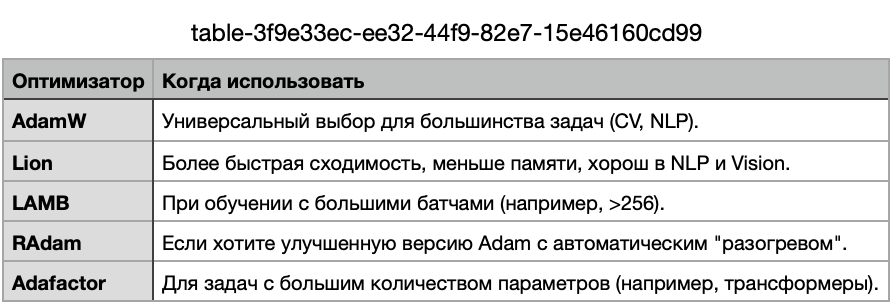
<!-- AdamW Универсальный выбор для большинства задач (CV, NLP).
Lion
Более быстрая сходимость, меньше памяти, хорош в NLP и Vision.
LAMB
При обучении с большими батчами (например, >256).
RAdam
Если хотите улучшенную версию Adam с автоматическим "разогревом".
Adafactor
Для задач с большим количеством параметров (например, трансформеры). -->

In [20]:
from timm import optim

In [21]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Параметры
optimizer_name = 'lion'          # или 'lion', 'lamb', 'rmsprop', 'adafactor', 'adamp' и др.
learning_rate = 1e-4
weight_decay = 0.01

# Создаём Lion-оптимизатор
optimizer = timm.optim.create_optimizer_v2(
    model,
    opt=optimizer_name,
    lr=learning_rate,
    weight_decay=weight_decay,
)

## Планировщик обучения

Другим полезным приемом будет использовать [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) `learning rate scheduler`. Планировщик скорости обучения динамически изменяет скорость обучения во время обучения модели. 
 
В наиболее простом случае планировщик скорости обучения задается из пакета `torch.optim.lr_scheduler` как одноцикловой планировщик. То есть он имеет только один цикл изменения скорости. 

Ниже показан пример визуализации для 4 типов планировщиков. 

> * Обратите внимание, что текущее значение скорости обучения можно получить как `optimizer.param_groups[0]["lr"]`.  
> * Также скорость може быть и установлена `optimizer.param_groups[0]["lr"]  = 0.01`
> * Всегда визуализируйте LR перед запуском долгого обучения.
> * Для fine-tuning: начинайте с LR в 10–100× меньше, чем при pre-training.
> * Используйте warmup, если batch size большой или данные зашумлены.

<blockquote>
    
Отметим, что также может быть использован планировщик `ReduceLROnPlateau`, который снижает скорость обучения автоматически при выходе валидации на плато.
    
```python

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(10):
        train(...)
        val_loss = validate(...)
        # Note that step should be called after validate()
        scheduler.step(val_loss)
```

Следует также отметить, что помимо расписания ниже приведен следующий код:
```python
    max_grad = 10
    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))
```

Такой прием позволяет ограничить значение градиента (`gradient clipping`): `lambda grad: torch.clamp(grad, -0.1, max_grad)`. Прием применяется для всех параметров, так как задан цикл. При этом данный прием записывается как дополнительная функция при расчете градиента. Это реализовано через т.н. `hook`. По средствам метода `register_hook` подобно `callback` каждому параметру ставится дополнительная функция в соответствие.

Также можно сделать расписание из timm scheduler

```python
scheduler, _ = timm.scheduler.create_scheduler_v2(
    optimizer,
    sched='cosine',
    num_epochs=100,
    warmup_epochs=10,
    min_lr=1e-6
)
```

<!-- Расписание (sched)	Класс в timm.scheduler	Описание	Основные параметры
'cosine'	CosineLRScheduler	Косинусное убывание скорости обучения с возможностью рестартов.	num_epochs"
'step'	StepLRScheduler	Уменьшает lr" на фиксированном шаге (например	 каждые "decay_epochs).
'multistep'	MultiStepLRScheduler	Уменьшает lr на каждом из указанных эпох (decay_milestones).	decay_milestones"
'poly'	PolyLRScheduler	Полиномиальное убывание lr. Хорошо работает в задачах сегментации.	power"
'tanh'	TanhLRScheduler	Убывание по гиперболическому тангенсу с возможностью рестартов.	num_epochs"
'plateau'	PlateauLRScheduler	Уменьшает lr"	 когда метрика перестаёт улучшаться (например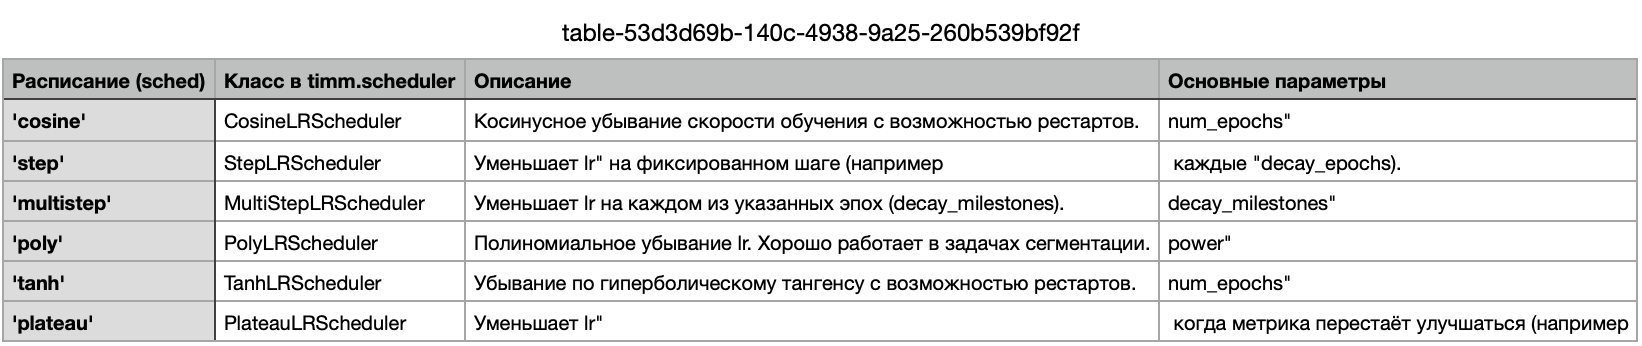 -->
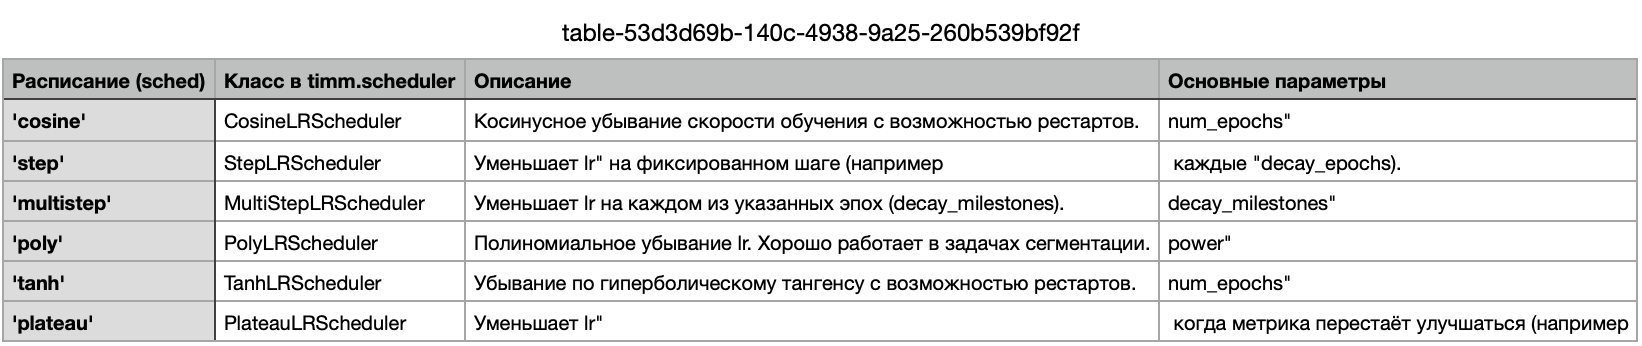 

Отметим, следующие [практики использования изменяющейся скорости обучения](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers):
* __Начните с фиксированной скорости__. Начните обучение с постоянной скорости обучения, чтобы установить базовый уровень и обеспечить начальную сходимость.
* __Настройте параметры планировщика__. Размер шага (`step_size`), гамма (`gamma`) и другие параметры планировщика сильно влияют на производительность модели. Поэкспериментируйте с различными настройками, чтобы найти оптимальный вариант для ваших данных и модели.
* __Следите за потерями и метриками__. Следите за метриками обучения и проверки. Планировщики скорости обучения могут помочь точно настроить модель, адаптируясь к ее изменяющимся потребностям во время обучения.

Когда следует использовать планирование скорости обучения:
* __Разреженные данные__. Для данных с разреженными признаками планирование может помочь модели сосредоточиться на менее распространенных признаках, тем самым повышая производительность.
* __Медленно и быстро обучающиеся признаки__. Не все признаки должны обновляться с одинаковой скоростью. Например, в нейронных сетях весам более ранних слоев может потребоваться больше времени для сходимости. Планирование может помочь ускорить их обновление.
* __Плато потерь__. Когда функция потерь сглаживается, указывая на то, что модель мало чему учится при текущей скорости обучения, планировщик может снизить скорость и вывести модель из колеи.

C:\Users\Ronkin\anaconda3\envs\py39\lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


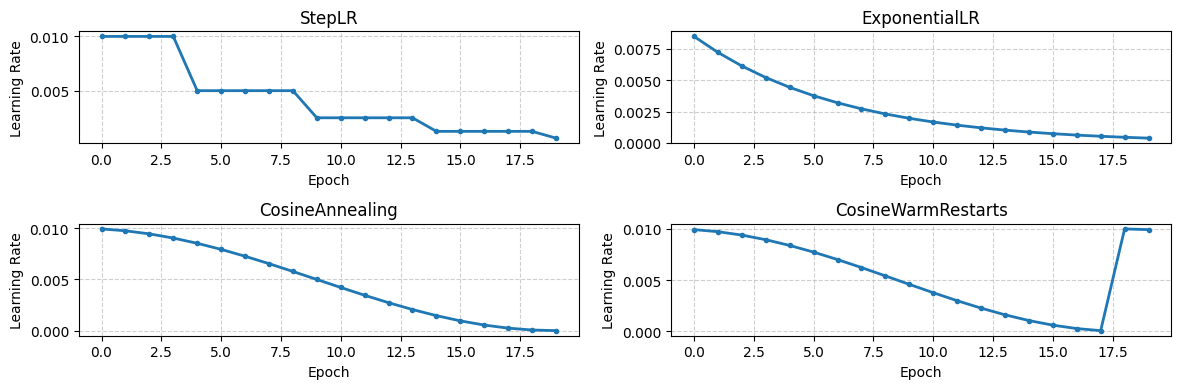

In [22]:
import matplotlib.pyplot as plt

# Гиперпараметры
epochs = 20
initial_lr = 0.01

# Создаём "фиктивный" оптимизатор (только для LR)
dummy_model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(dummy_model.parameters(), lr=initial_lr)

schedulers = {
    'StepLR': torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5),
    'ExponentialLR': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85),
    'CosineAnnealing': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6),
    'CosineWarmRestarts': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=19, T_mult=1, eta_min=1e-6
    )
}

# Собираем LR по эпохам
lrs = {}
for name in schedulers:
    lrs[name] = []

for name, scheduler in schedulers.items():

    for param_group in optimizer.param_groups:
        param_group['lr'] = initial_lr

    for epoch in range(epochs):
        scheduler.step()
        lrs[name].append(optimizer.param_groups[0]['lr'])
        
# Визуализация
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
axs = axs.ravel()

for i, (name, lr_vals) in enumerate(lrs.items()):
    axs[i].plot(range(epochs), lr_vals, marker='o', linewidth=2, markersize=3)
    axs[i].set_title(name, fontsize=12)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Learning Rate')
    axs[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [23]:
from timm import scheduler

In [24]:
scheduler, _ = timm.scheduler.create_scheduler_v2(
    optimizer,
    sched='cosine',
    num_epochs=100,
    warmup_epochs=10,
    min_lr=1e-6
)

## Метрики обучения

Метрики обучения возьмем из библиотеки [`torchmetrics`](https://github.com/Lightning-AI/torchmetrics) для библиотеки есть актуальный [GitHub](https://github.com/Lightning-AI/torchmetrics)  и [очень старая документация](https://torchmetrics.readthedocs.io/en/v0.8.2/index.html).

Для объектов классов заданных метрик также используем т.н. "захват функции" (`wrapped_metrics`) - получение объекта класса из заданного в словаре класса.

In [25]:
from torchmetrics import *

In [26]:
metrics = {
    "acc": Accuracy(task="multiclass", num_classes=num_classes).to(device),
    "prec": Precision(task="multiclass", num_classes=num_classes, average="macro").to(device),
    "rec": Recall(task="multiclass", num_classes=num_classes, average="macro").to(device),
    "f1": F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device),
}
# Оборачиваем для совместимости
wrapped_metrics = {k: lambda pred, target, fn=fn: fn(pred, target) for k, fn in metrics.items()}

In [27]:
wrapped_metrics

{'acc': <function __main__.<dictcomp>.<lambda>(pred, target, fn=MulticlassAccuracy())>,
 'prec': <function __main__.<dictcomp>.<lambda>(pred, target, fn=MulticlassPrecision())>,
 'rec': <function __main__.<dictcomp>.<lambda>(pred, target, fn=MulticlassRecall())>,
 'f1': <function __main__.<dictcomp>.<lambda>(pred, target, fn=MulticlassF1Score())>}

> Напомним, что
>
> * `average="macro"` - среднее по классам,
>  * `average="micro"` - среднее по всем записям
>  * Разница важна для метрик `Precision, Recall, F1Score` при работе с несбалансированными классами.

# Кросс-валидация

* k-folds: 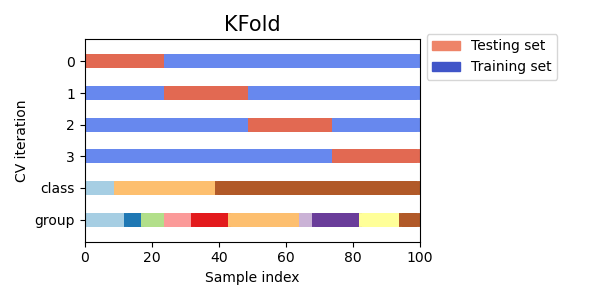
* Stratified K-fold: 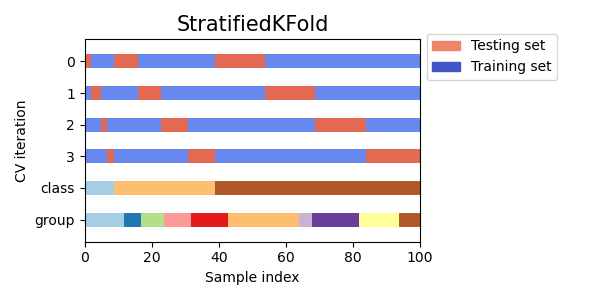
* Nested CV: 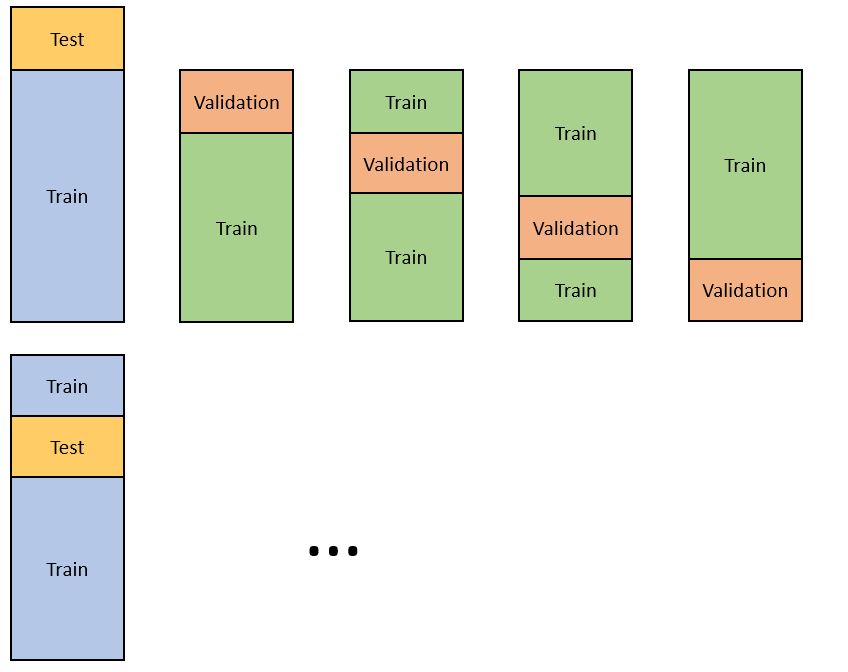 

## Функция потерь

<blockquote>
 
 Иногда в функцию потерь также добавляют параметр [`label_smoothing`](https://paperswithcode.com/method/label-smoothing), выставляя его небольшим. При этом итоговая метка класса формируется как $$ y_s = (1-\eta y) + U[0, \eta/K] $$ где $\eta$ — весовой коэффициент, $K$ — число классов, а $U[0, \eta/K]$ — равномерное распределение. То есть $y_s$ представляет собой вектор, где основной класс имеет значение в диапазоне $(0,1)$, а остаток этого диапазона «размыт» между значениями остальных классов. В таком случае ожидается, что подразумеваемая функция активации $softmax$ не будет выходить в насыщение, что снизит вероятность переобучения слоя принятия решений. Сегодня `label_smoothing` в оригинальной функции потерь, как это показано ниже. 
```python 
    nn.CrossEntropyLoss(label_smoothing = ...)
```
 </blockquote>

## Обучение модели

### Загрузка модели.

In [28]:
model = timm.create_model('mobilevitv2_050', 
                          pretrained=True, 
                          num_classes=len(traindata.classes), 
                          in_chans=3)

# Замораживаем все параметры
for param in model.parameters():
    param.requires_grad = False 

In [29]:
# Получаем имя слоя головы через get_classifier()
classifier_name = model.get_classifier().__class__.__name__

# Находим модуль головы (обычно это 'head', 'classifier', 'fc' и т.п.)
# timm модели обычно используют 'head' или 'classifier'
# Проверим, есть ли атрибут 'head'
if hasattr(model, 'head'):
    head_module = model.head
elif hasattr(model, 'classifier'):
    head_module = model.classifier
else:
    # Если ни один из них не найден, пробуем получить через get_classifier()
    # Но в этом случае мы не знаем имя атрибута, просто разморозим сам объект
    classifier_obj = model.get_classifier()
    classifier_obj.requires_grad_(True)
    # Инициализируем его
    init_classifier(classifier_obj)
    head_module = None  # Уже инициализировали

if head_module is not None:
    # Размораживаем только голову
    head_module.requires_grad_(True)
    
    # Инициализируем только голову
    head_module.apply(init_classifier)



In [30]:
summary(model, (1,3,224,224))

Layer (type:depth-idx)                                       Output Shape              Param #
ByobNet                                                      [1, 2]                    --
├─ConvNormAct: 1-1                                           [1, 16, 112, 112]         --
│    └─Conv2d: 2-1                                           [1, 16, 112, 112]         (432)
│    └─BatchNormAct2d: 2-2                                   [1, 16, 112, 112]         32
│    │    └─Identity: 3-1                                    [1, 16, 112, 112]         --
│    │    └─SiLU: 3-2                                        [1, 16, 112, 112]         --
├─Sequential: 1-2                                            [1, 256, 8, 8]            --
│    └─Sequential: 2-3                                       [1, 32, 112, 112]         --
│    │    └─BottleneckBlock: 3-3                             [1, 32, 112, 112]         (2,016)
│    └─Sequential: 2-4                                       [1, 64, 56, 56]           

In [31]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print('trainable p:', trainable_params, 'all p:', total_params)

trainable p: 514 all p: 1114107


In [32]:
EPOCH = 30

In [33]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = timm.optim.create_optimizer_v2(
    trainable_parameters,
opt='adamw',
    lr=1e-3,
    weight_decay=0.001
)
scheduler, _ = timm.scheduler.create_scheduler_v2(
    optimizer,
    sched='cosine',
    num_epochs=EPOCH,
    warmup_epochs=2,
    min_lr=1e-4
)

In [40]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from contextlib import nullcontext
import gc
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def batch_size_finder(model, train_loader, optimizer_class, criterion, initial_batch_size=32,
                      max_batch_size=512, growth_factor=1.5, num_steps_per_batch=10,
                      device='cuda', use_amp=False, verbose=True, plot=True, 
                      target_metric='throughput'):
    """
    Определение оптимального размера батча для больших моделей.

    Parameters:
    - model: torch.nn.Module
    - train_loader: torch.utils.data.DataLoader (с малым batch_size)
    - optimizer_class: класс оптимизатора (например, torch.optim.Adam)
    - criterion: loss function
    - initial_batch_size: начальный размер батча для тестирования
    - max_batch_size: максимальный размер батча для тестирования
    - growth_factor: множитель увеличения batch_size
    - num_steps_per_batch: количество шагов для оценки каждого batch_size
    - device: устройство ('cuda' или 'cpu')
    - use_amp: использовать автоматическое масштабирование точности (AMP)
    - verbose: выводить прогресс
    - plot: строить график
    - target_metric: целевая метрика ('throughput' или 'stability')

    Returns:
    - batch_sizes: список протестированных размеров батча
    - metrics: список значений метрики (throughput или loss stability)
    - optimal_batch_size: оптимальный размер батча
    """
    
    # Проверка на CUDA OOM ошибки
    def test_batch_size(batch_size, num_steps=5):
        """Тестирование возможности использования заданного batch_size."""
        try:
            # Создание временной модели и оптимизатора
            temp_model = type(model)(**model.__init__.__code__.co_consts[0]) \
                        if hasattr(model, '__init__') else model
            temp_model = nn.Sequential(*list(model.children())[:2]).to(device) if len(list(model.children())) > 1 else model.to(device)
            temp_model.eval()
            
            # Создание фиктивных данных
            sample_input = torch.randn(batch_size, *next(iter(train_loader))[0].shape[1:]).to(device)
            sample_target = torch.randint(0, model.fc.out_features if hasattr(model, 'fc') else 10, 
                                        (batch_size,)).to(device)
            
            # Тестовый проход
            with autocast() if use_amp else nullcontext():
                with torch.no_grad():
                    output = temp_model(sample_input)
                    loss = criterion(output, sample_target)
            
            del sample_input, sample_target, output, loss
            if hasattr(temp_model, 'module'):
                del temp_model.module
            del temp_model
            torch.cuda.empty_cache()
            return True
            
        except RuntimeError as e:
            if 'out of memory' in str(e):
                return False
            else:
                raise e
    
    # Оценка производительности для заданного batch_size
    def evaluate_batch_size(batch_size, num_steps=num_steps_per_batch):
        """Оценка метрик для заданного размера батча."""
        # Создание модели и оптимизатора
        temp_model = type(model)(**{k: v for k, v in model.__dict__.items() 
                                  if not k.startswith('_')}).to(device) \
                    if hasattr(model, '__dict__') else model.to(device)
        temp_optimizer = optimizer_class(temp_model.parameters(), lr=1e-3)
        temp_model.train()
        
        scaler = GradScaler() if use_amp else None
        
        times = []
        losses = []
        memory_usages = []
        
        # Итератор данных
        data_iter = iter(train_loader)
        
        for step in range(num_steps):
            try:
                # Сборка батча нужного размера
                inputs_batch = []
                targets_batch = []
                
                count = 0
                while count < batch_size:
                    try:
                        inputs, targets = next(data_iter)
                        inputs, targets = inputs.to(device), targets.to(device)
                        
                        # Добавляем части в батч
                        needed = batch_size - count
                        if len(inputs) >= needed:
                            inputs_batch.append(inputs[:needed])
                            targets_batch.append(targets[:needed])
                            count += needed
                        else:
                            inputs_batch.append(inputs)
                            targets_batch.append(targets)
                            count += len(inputs)
                    except StopIteration:
                        data_iter = iter(train_loader)
                        continue
                
                # Конкатенация в один батч
                inputs = torch.cat(inputs_batch, dim=0)[:batch_size]
                targets = torch.cat(targets_batch, dim=0)[:batch_size]
                
                if len(inputs) < batch_size:
                    # Дополнение до нужного размера (если нужно)
                    pad_size = batch_size - len(inputs)
                    inputs = torch.cat([inputs, inputs[:pad_size]], dim=0)
                    targets = torch.cat([targets, targets[:pad_size]], dim=0)
                
            except Exception:
                # Если данные закончились, используем последний батч
                continue
            
            # Измерение времени
            start_time = time.time()
            
            # Прямой проход
            context = autocast() if use_amp else nullcontext()
            with context:
                outputs = temp_model(inputs)
                loss = criterion(outputs, targets)
            
            # Обратный проход
            temp_optimizer.zero_grad()
            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(temp_optimizer)
                scaler.update()
            else:
                loss.backward()
                temp_optimizer.step()
            
            # Измерение времени и памяти
            end_time = time.time()
            times.append(end_time - start_time)
            losses.append(loss.item())
            
            if device == 'cuda':
                memory_usages.append(torch.cuda.memory_allocated(device))
            
        # Очистка
        del temp_model, temp_optimizer
        if scaler:
            del scaler
        torch.cuda.empty_cache()
        
        # Вычисление метрик
        avg_time = np.mean(times)
        throughput = batch_size / avg_time if avg_time > 0 else 0
        loss_std = np.std(losses)
        avg_memory = np.mean(memory_usages) if memory_usages else 0
        
        return {
            'throughput': throughput,
            'loss_std': loss_std,
            'time_per_batch': avg_time,
            'avg_loss': np.mean(losses),
            'memory_usage': avg_memory
        }
    
    # Генерация последовательности размеров батча
    batch_sizes = []
    current_batch_size = initial_batch_size
    
    while current_batch_size <= max_batch_size:
        if test_batch_size(int(current_batch_size)):
            batch_sizes.append(int(current_batch_size))
        current_batch_size *= growth_factor
    
    if verbose:
        print(f"Testing batch sizes: {batch_sizes}")
    
    # Оценка метрик для каждого размера батча
    results = []
    metrics_values = {'throughput': [], 'stability': [], 'memory': []}
    
    for i, batch_size in enumerate(batch_sizes):
        if verbose:
            print(f"Testing batch_size: {batch_size}")
        
        try:
            metrics = evaluate_batch_size(batch_size)
            results.append({
                'batch_size': batch_size,
                'metrics': metrics
            })
            
            metrics_values['throughput'].append(metrics['throughput'])
            metrics_values['stability'].append(1.0 / (metrics['loss_std'] + 1e-8))  # Обратное значение для стабильности
            metrics_values['memory'].append(metrics['memory_usage'] / 1024**3)  # в GB
            
            if verbose:
                print(f"  Throughput: {metrics['throughput']:.2f} samples/sec")
                print(f"  Loss std: {metrics['loss_std']:.4f}")
                print(f"  Memory usage: {metrics['memory_usage'] / 1024**3:.2f} GB")
                
        except RuntimeError as e:
            if 'out of memory' in str(e):
                if verbose:
                    print(f"  Batch size {batch_size} caused OOM, stopping...")
                break
            else:
                raise e
    
    if not results:
        raise RuntimeError("No batch size could be tested successfully - all caused OOM")
    
    # Определение оптимального размера батча
    batch_sizes_tested = [r['batch_size'] for r in results]
    throughputs = [r['metrics']['throughput'] for r in results]
    stabilities = [1.0 / (r['metrics']['loss_std'] + 1e-8) for r in results]
    
    if target_metric == 'throughput':
        # Максимизация throughput с учетом ограничений на стабильность
        # Ищем баланс между высокой производительностью и приемлемой стабильностью
        normalized_throughput = (np.array(throughputs) - np.min(throughputs)) / (np.max(throughputs) - np.min(throughputs) + 1e-8)
        normalized_stability = (np.array(stabilities) - np.min(stabilities)) / (np.max(stabilities) - np.min(stabilities) + 1e-8)
        
        # Взвешенная комбинация: 70% throughput, 30% stability
        combined_score = 0.7 * normalized_throughput + 0.3 * normalized_stability
        optimal_idx = np.argmax(combined_score)
        
    elif target_metric == 'stability':
        # Максимизация стабильности с минимальным падением throughput
        optimal_idx = np.argmax(stabilities)
        # Но проверяем, что throughput не слишком низкий
        min_acceptable_throughput = 0.5 * max(throughputs)  # Не ниже 50% максимума
        valid_indices = [i for i in range(len(throughputs)) if throughputs[i] >= min_acceptable_throughput]
        if valid_indices:
            valid_stabilities = [stabilities[i] for i in valid_indices]
            optimal_idx = valid_indices[np.argmax(valid_stabilities)]
    
    optimal_batch_size = batch_sizes_tested[optimal_idx]
    
    # Построение графиков
    if plot:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Throughput vs Batch Size
        axes[0, 0].plot(batch_sizes_tested, throughputs, 'b-o')
        axes[0, 0].axvline(x=optimal_batch_size, color='red', linestyle='--', 
                          label=f'Optimal: {optimal_batch_size}')
        axes[0, 0].set_xlabel('Batch Size')
        axes[0, 0].set_ylabel('Throughput (samples/sec)')
        axes[0, 0].set_title('Throughput vs Batch Size')
        axes[0, 0].grid(True, linestyle='--', alpha=0.6)
        axes[0, 0].legend()
        
        # Loss Stability vs Batch Size
        axes[0, 1].plot(batch_sizes_tested, [1/x if x > 0 else float('inf') for x in [r['metrics']['loss_std'] for r in results]], 'g-o')
        axes[0, 1].axvline(x=optimal_batch_size, color='red', linestyle='--',
                          label=f'Optimal: {optimal_batch_size}')
        axes[0, 1].set_xlabel('Batch Size')
        axes[0, 1].set_ylabel('Stability (1/loss_std)')
        axes[0, 1].set_title('Loss Stability vs Batch Size')
        axes[0, 1].grid(True, linestyle='--', alpha=0.6)
        axes[0, 1].legend()
        
        # Memory Usage vs Batch Size
        memory_gb = [r['metrics']['memory_usage'] / 1024**3 for r in results]
        axes[1, 0].plot(batch_sizes_tested, memory_gb, 'r-o')
        axes[1, 0].axvline(x=optimal_batch_size, color='red', linestyle='--',
                          label=f'Optimal: {optimal_batch_size}')
        axes[1, 0].set_xlabel('Batch Size')
        axes[1, 0].set_ylabel('GPU Memory (GB)')
        axes[1, 0].set_title('Memory Usage vs Batch Size')
        axes[1, 0].grid(True, linestyle='--', alpha=0.6)
        axes[1, 0].legend()
        
        # Combined Score
        axes[1, 1].plot(batch_sizes_tested, combined_score if target_metric == 'throughput' else normalized_stability, 'm-o')
        axes[1, 1].axvline(x=optimal_batch_size, color='red', linestyle='--',
                          label=f'Optimal: {optimal_batch_size}')
        axes[1, 1].set_xlabel('Batch Size')
        axes[1, 1].set_ylabel('Combined Score')
        axes[1, 1].set_title(f'Optimization Target: {target_metric}')
        axes[1, 1].grid(True, linestyle='--', alpha=0.6)
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.suptitle('Batch Size Finder Results', fontsize=16, y=1.02)
        plt.show()
    
    if verbose:
        print(f"\nOptimal batch size: {optimal_batch_size}")
        print(f"Target metric: {target_metric}")
        print(f"Final metrics for optimal batch size:")
        optimal_metrics = results[optimal_idx]['metrics']
        print(f"  Throughput: {optimal_metrics['throughput']:.2f} samples/sec")
        print(f"  Loss std: {optimal_metrics['loss_std']:.4f}")
        print(f"  Memory usage: {optimal_metrics['memory_usage'] / 1024**3:.2f} GB")
    
    return batch_sizes_tested, throughputs, optimal_batch_size

# Улучшения и рекомендации:

"""
Улучшения для функции batch_size_finder:

1. **Проверка на OOM:** Предварительная проверка возможности использования batch_size
2. **Многокритериальная оптимизация:** Учет throughput, стабильности и потребления памяти
3. **Поддержка AMP:** Учет автоматического масштабирования точности
4. **Гибкая целевая метрика:** Возможность выбора между производительностью и стабильностью
5. **Комплексная визуализация:** Графики для всех ключевых метрик
6. **Оптимизация памяти:** Очистка временных моделей и данных после каждой итерации

Дополнительные рекомендации:
- Для очень больших моделей можно использовать gradient accumulation вместо большого batch_size
- Рассмотреть использование progressive resizing (постепенное увеличение размера изображений)
- При использовании large batch_size может потребоваться корректировка learning rate (Linear Scaling Rule)
- Для распределенного обучения оптимальный глобальный batch_size может отличаться
"""

'\nУлучшения для функции batch_size_finder:\n\n1. **Проверка на OOM:** Предварительная проверка возможности использования batch_size\n2. **Многокритериальная оптимизация:** Учет throughput, стабильности и потребления памяти\n3. **Поддержка AMP:** Учет автоматического масштабирования точности\n4. **Гибкая целевая метрика:** Возможность выбора между производительностью и стабильностью\n5. **Комплексная визуализация:** Графики для всех ключевых метрик\n6. **Оптимизация памяти:** Очистка временных моделей и данных после каждой итерации\n\nДополнительные рекомендации:\n- Для очень больших моделей можно использовать gradient accumulation вместо большого batch_size\n- Рассмотреть использование progressive resizing (постепенное увеличение размера изображений)\n- При использовании large batch_size может потребоваться корректировка learning rate (Linear Scaling Rule)\n- Для распределенного обучения оптимальный глобальный batch_size может отличаться\n'

In [41]:

batch_size_finder(model, 
                  trainloader, 
                  optimizer,
                  criterion, 
                  initial_batch_size=4,
                  max_batch_size=512, 
                  growth_factor=1.5, 
                  num_steps_per_batch=10,
                  device=device, 
                  use_amp=False, 
                  verbose=True, 
                  plot=True, 
                  target_metric='throughput')

TypeError: timm.models.byobnet.ByobNet() argument after ** must be a mapping, not str

Iteration 0/100, LR: 1.00e-07, Loss: 0.7072
Iteration 10/100, LR: 6.31e-07, Loss: 0.7056
Iteration 20/100, LR: 3.98e-06, Loss: 0.7045
Iteration 30/100, LR: 2.51e-05, Loss: 0.7033
Iteration 40/100, LR: 1.58e-04, Loss: 0.7031
Iteration 50/100, LR: 1.00e-03, Loss: 0.6990
Iteration 60/100, LR: 6.31e-03, Loss: 0.6764
Iteration 70/100, LR: 3.98e-02, Loss: 0.5805
Iteration 80/100, LR: 2.51e-01, Loss: 0.4949
Iteration 90/100, LR: 1.58e+00, Loss: 0.4595


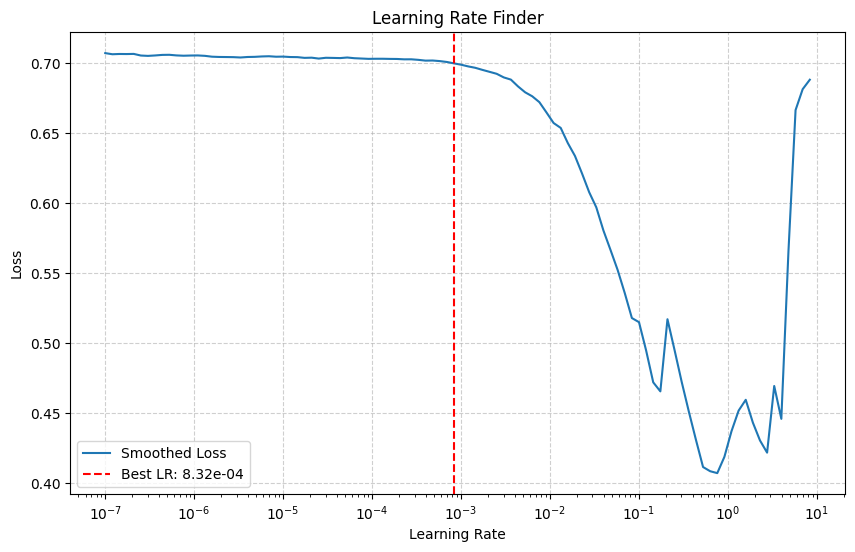

(array([1.00000000e-07, 1.20226443e-07, 1.44543977e-07, 1.73780083e-07,
        2.08929613e-07, 2.51188643e-07, 3.01995172e-07, 3.63078055e-07,
        4.36515832e-07, 5.24807460e-07, 6.30957344e-07, 7.58577575e-07,
        9.12010839e-07, 1.09647820e-06, 1.31825674e-06, 1.58489319e-06,
        1.90546072e-06, 2.29086765e-06, 2.75422870e-06, 3.31131121e-06,
        3.98107171e-06, 4.78630092e-06, 5.75439937e-06, 6.91830971e-06,
        8.31763771e-06, 1.00000000e-05, 1.20226443e-05, 1.44543977e-05,
        1.73780083e-05, 2.08929613e-05, 2.51188643e-05, 3.01995172e-05,
        3.63078055e-05, 4.36515832e-05, 5.24807460e-05, 6.30957344e-05,
        7.58577575e-05, 9.12010839e-05, 1.09647820e-04, 1.31825674e-04,
        1.58489319e-04, 1.90546072e-04, 2.29086765e-04, 2.75422870e-04,
        3.31131121e-04, 3.98107171e-04, 4.78630092e-04, 5.75439937e-04,
        6.91830971e-04, 8.31763771e-04, 1.00000000e-03, 1.20226443e-03,
        1.44543977e-03, 1.73780083e-03, 2.08929613e-03, 2.511886

In [39]:
lr_finder(model, 
          trainloader, 
          optimizer, 
          criterion, 
          start_lr=1e-7,
          end_lr=1,
          num_iter=100,
          step_mode='exp', 
          smooth_f=0.05, 
          diverge_th=5, 
          device=device, 
          accumulation_steps=1, 
          use_amp=False, 
          verbose=True, 
          plot=True)

In [34]:
# trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
# optimizer = torch.optim.AdamW(trainable_parameters, lr=9e-4, weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3)
criterion=torch.nn.CrossEntropyLoss().to(device)
model.to(device);


In [35]:
task = 'multiclass'

metrics = {
    'acc': Accuracy(task=task, num_classes=num_classes).to(device),
    'prec': Precision(task=task, num_classes=num_classes, average='macro').to(device),
    'rec': Recall(task=task, num_classes=num_classes, average='macro').to(device),
    'f1': F1Score(task=task, num_classes=num_classes, average='macro').to(device),
}

# torchmetrics возвращает tensor → оборачиваем в лямбду для совместимости
def make_metric_fn(metric_obj):
    return lambda preds, target: metric_obj(preds, target)

wrapped_metrics = {name: make_metric_fn(metric) for name, metric in metrics.items()}

### Обучение модели

In [161]:

history, batch_hist = fit(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=wrapped_metrics,
    epochs=20,
    scheduler=scheduler,
    patience=7,
    min_delta=0.0001,
    device=device,
    checkpoint_path='best_model_checkpoint.pt',
    verbose=True,
    monitor_metric='acc',                  # early stopping по F1
    mode='max',
    return_batch_history = True,
)

Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 01 | Time: 4.4s | LR: 5.05e-04 | Train Loss: 0.7018 | Val Loss: 0.7089 | Val acc: 0.2986 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 02 | Time: 4.0s | LR: 9.90e-04 | Train Loss: 0.6880 | Val Loss: 0.6760 | Val acc: 0.7417 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 03 | Time: 4.0s | LR: 9.78e-04 | Train Loss: 0.6470 | Val Loss: 0.6236 | Val acc: 0.8667 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 04 | Time: 4.0s | LR: 9.61e-04 | Train Loss: 0.5990 | Val Loss: 0.5832 | Val acc: 0.8417 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 05 | Time: 4.0s | LR: 9.40e-04 | Train Loss: 0.5581 | Val Loss: 0.5540 | Val acc: 0.8368 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 06 | Time: 4.0s | LR: 9.14e-04 | Train Loss: 0.5247 | Val Loss: 0.5248 | Val acc: 0.8368 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 07 | Time: 4.0s | LR: 8.84e-04 | Train Loss: 0.4936 | Val Loss: 0.4951 | Val acc: 0.8556 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 08 | Time: 4.0s | LR: 8.51e-04 | Train Loss: 0.4709 | Val Loss: 0.4809 | Val acc: 0.8368 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 09 | Time: 4.0s | LR: 8.15e-04 | Train Loss: 0.4443 | Val Loss: 0.4541 | Val acc: 0.8618 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Time: 4.2s | LR: 7.75e-04 | Train Loss: 0.4612 | Val Loss: 0.4432 | Val acc: 0.8792 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Задания

**1.** Проверьте, как влияют те или иные режимы инициализации на качество работы нейронной сети. Например, инициализация постоянными величинами `nn.init.constant_(m.weight, constant_weight)`.

__2.__  В ряде [случаев](https://discuss.pytorch.org/t/tricks-for-being-able-to-use-a-higher-learning-rate/142179) рекомендуется стратегия обучения, когда изначально используется крайне низкая скорость обучения в течение нескольких эпох, чтобы веса модели настроились в нужном направлении. Такие эпохи будут сравнительно бесполезными с точки зрения результата обучения, но повышают стабильность экспериментов. Затем скорость обучения резко увеличивают и начинают плавно снижать. Предполагается, что после первоначальной настройки весов они могут быстро обучиться в нужном направлении. __Предлагается__ реализовать эту стратегию самостоятельно.

> Также иногда используют циклическую скорость обучения для большого числа эпох.

<code style="color : red">__3.*__</code> В ряде [работ](https://openreview.net/pdf?id=B1Yy1BxCZ) рекомендуется вместе с изменением скорости обучения (с ее снижением) [увеличивать размер батча](https://stackoverflow.com/questions/53033556/how-should-the-learning-rate-change-as-the-batch-size-change). __Предлагается__ реализовать эту стратегию обучения самостоятельно. 

> [Иногда](https://ar5iv.labs.arxiv.org/abs/1803.09820) также рекомендуют уменьшать затухание весов с ростом эпохи обучения (параметр `L2` регуляризации — `weight_decay` в оптимизаторах). Если используется параметр `momentum`, то он должен снижаться с увеличением скорости обучения [или циркулировать](https://ar5iv.labs.arxiv.org/abs/1803.09820).

<code style="color : red">__4.*__</code> Настройка параметров обучения может быть выполнена не только по блокам модели, но и по отдельным параметрам. Например, если используется `SGD with weight_decay`, иногда полезно отключить `weight_decay` для параметра смещения. Это можно сделать следующим образом.
    
```python
    bias_params = [p for name, p in self.named_parameters() if 'bias' in name]
    others = [p for name, p in self.named_parameters() if 'bias' not in name]

    optim.SGD([
                    {'params': others},
                    {'params': bias_params, 'weight_decay': 0}
                ], weight_decay=1e-2, lr=1e-2)
```
> Отметим, что также [в ряде случаев](https://github.com/NVIDIA/DeepLearningExamples/blob/8d8b21a933fff3defb692e0527fca15532da5dc6/PyTorch/Classification/ConvNets/image_classification/training.py)  'weight_decay' не используется для параметров батч-нормализации.

__Предлагается__ проверить качество такого оптимизатора самостоятельно.

<code style="color : red">__5.*__</code> Иногда в функцию потерь также добавляют параметр [`label_smoothing`](https://paperswithcode.com/method/label-smoothing), выставляя его небольшим. При этом итоговая метка класса формируется как $$ y_s = (1-\eta y) + U[0, \eta/K] $$ где $\eta$ — весовой коэффициент, $K$ — число классов, а $U[0, \eta/K]$ — равномерное распределение. То есть $y_s$ представляет собой вектор, где основной класс имеет значение в диапазоне $(0,1)$, а остаток этого диапазона «размыт» между значениями остальных классов. В таком случае ожидается, что подразумеваемая функция активации $softmax$ не будет выходить в насыщение, что снизит вероятность переобучения слоя принятия решений. Сегодня `label_smoothing` в оригинальной функции потерь, как это показано ниже. __Предлагается__ попробовать использовать эту функцию самостоятельно.

```python 
    nn.CrossEntropyLoss(label_smoothing = ...)
```